## **1B.** 

-   Calculate $\hat{R}$ for the random walk Metropolis algorithm with N
    = 2000, s=0.001 and J=4
-   Keeping N and J fixed, provide a plot of the values of $\hat{R}$
    over a grid of s values in the interval between 0.001 and 1 (this
    will show us convergence behaviour visually)...


### Method

The question asks that I use a sequence of mathematical operations to
arrive at a value for $\hat{R}$

I can arrive at an output of $\hat{R}$ using simple means and variances
that come as standard in python and R. Hence we use these to construct
the function `compute_R_hat()`

i.  Enumerate a number ( J ) of sequences (N) of $x_{0},...,x_{N}$, using
    different initial values x0.

Each chain should be denoted by 
$(x_{0}^{j},x_{1}^{j},...,x_{N}^{j})$ for $j = 1,2,...,J$

    If `J = 4`, then `x0_initial_values = np.random.randn(J)` captures
    initial random values of our 4 chains. Within our function we then
    combine our chains in an array data structure and store it in the
    variable named `chains`

    `chains = np.array([random_walk_metropolis(N, s, x0) for x0 in x0_initial_values])`

ii. $M_{j} = \frac{1}{N}\sum_{i=1}^{N} x_{i}^{(j)}$ This expression is a
    simple mean for each chain in our array "chains":
    `Mj = chains.mean(axis=1)`. Here we calculate the mean for each
    chain (axis one goes row by row, and we have 4 rows in our numpy
    array).

iii. The within sample variance of chain j is a simple variance
     calculation `var()`for each
     chain $V_{j} = \frac{1}{N}\sum_{i=1}^N (x_{i}^{(j)} − M_j)^{2}$

     `Vj = chains.var(axis=1)` so we calculate the variance of each
     chain.

iv. The overall within sample variance W is a point estimate of the
    variance of the variances of each chain
    $W = \frac{1}{J}\sum_{j=1}^{J}V_{j}$

    `W = Vj.mean()`

v.  Define and compute the overall sample mean M as the mean of the
    means of our chains...

$M = \frac{1}{J} \sum_{j=1}^{J} M_{j}$

    `M = Mj.mean()`remember that chains is an array, and Mj stores an
    array of means.

vi. and the between sample variance B is the variance of each chain's
    mean from the overall mean of all the chains
    $B = \frac{1}{J}\sum_{j=1}^{J} (M_{j} - M)^{2}$

    `B = N/(J-1) * np.var(Mj, ddof=1)` note that we have to scale the
    between sample variance by N in order to get B (variance estimate
    based on means of each chain) to the same order of magnitude as W
    (variance based on individual observations).

vii. Compute the R_hat value as $\hat{R} = \sqrt\frac{B+W}{W}$

With a small adjustment according to the work of Gelman and
Rubin 1992. We include the $\hat{Var}^{+}$ statistic, and use that
as our numerator instead of B+W

     `var_hat_plus = ((N-1)/N) * W + (1/N) * B`

     `R_hat = np.sqrt((var_hat_plus) / W)`

     i.  This is because Using B+W directly as the numerator without
         adjusting for the sample size N and the number of chains J may
         lead to underestimation of the true variance of the target
         distribution. 
         
$\hat{Var}^{+}$  method aims to slightly overestimate the true variance of the target distribution. This
overestimation is intentional and acts as a conservative
measure, ensuring that if the calculated $\hat{R}$ value is close to 1, it is more likely that the chains have indeed converged.

In general, values of $\hat{R}$ close to 1 indicate convergence, and it
is usually desired for $\hat{R}$ to be lower than 1.05.

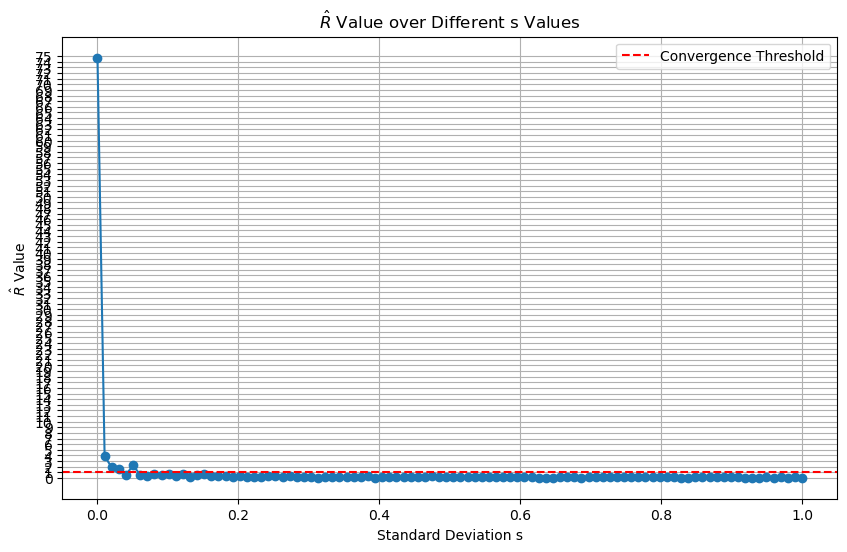

In [1]:
#VERSION 1: This was the first version of the code in which I failed to achieve a stable convergence value of 1

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
import os

# Define the target distribution PDF and its log
def log_f(x):
    return np.log(0.5) - np.abs(x)
# Random walk Metropolis algorithm
def random_walk_metropolis(N, s, x0):
    samples = np.zeros(N)
    samples[0] = x0  # Initial value

    for i in range(1, N):
        x_star = norm.rvs(loc=samples[i-1], scale=s)  # Propose a new state
        log_r = log_f(x_star) - log_f(samples[i-1])  # Compute log of the ratio
        u = np.log(uniform.rvs())  # Log of uniform random number for comparison

        if u < log_r:
            samples[i] = x_star  # Accept the new state
        else:
            samples[i] = samples[i-1]  # Reject the new state

    return samples

# Function to compute R hat
def compute_R_hat(N, s, J, x0_initial_values):
    chains = np.array([random_walk_metropolis(N, s, x0) for x0 in x0_initial_values])
    Mj = chains.mean(axis=1)
    Vj = chains.var(axis=1)
    W = Vj.mean() #Sum all variances and divide by J....should we do axis=1???
    M = Mj.mean() #should we do axis=1???
    B = N / J * np.sum((Mj - M)**2) #this was scaled by N as well...
    R_hat = np.sqrt((B/W + 1)/N)
    return R_hat

# Parameters
N = 2000
J = 4
s_values = np.linspace(0.001, 1, 100)
x0_initial_values = np.random.randn(J)  # Different initial values for each chain

# Calculate R_hat for each s value
R_hats = np.array([compute_R_hat(N, s, J, x0_initial_values) for s in s_values])

# Plot R_hat over s values with y-axis adjustments
plt.figure(figsize=(10, 6))
plt.plot(s_values, R_hats, '-o')
plt.xlabel('Standard Deviation s')
plt.ylabel('$\hat{R}$ Value')
plt.title('$\hat{R}$ Value over Different s Values')
plt.axhline(1.05, color='red', linestyle='--', label='Convergence Threshold')
plt.yticks(np.arange(np.floor(min(R_hats)), np.ceil(max(R_hats))+1, 1))  # Adjusting y-axis increments to 1
plt.legend()
plt.grid(True)
plt.show()


#SEE THE NEXT CODE BLOCK PLEASE

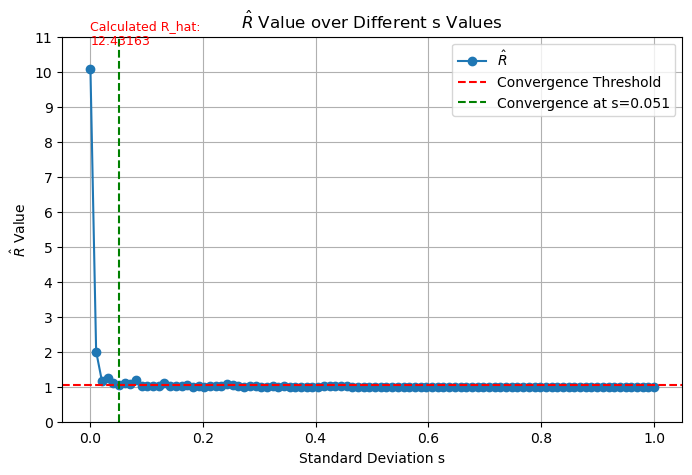

In [2]:
#VERSION 2: This was the second version of the code in which I applied the Gelman-Rubin 1992 Var_hat adjustment to achieve a stable convergence value of 1

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
import os

# Define the target distribution PDF and its log
def log_f(x):
    return np.log(0.5) - np.abs(x)

# Random walk Metropolis algorithm
def random_walk_metropolis(N, s, x0):
    samples = np.zeros(N)
    samples[0] = x0  # Initial value

    for i in range(1, N):
        x_star = norm.rvs(loc=samples[i-1], scale=s)  # Propose a new state
        log_r = log_f(x_star) - log_f(samples[i-1])  # Compute log of the ratio
        log_u = np.log(uniform.rvs())  # Log of uniform random number for comparison

        if log_u < log_r:
            samples[i] = x_star  # Accept the new state
        else:
            samples[i] = samples[i-1]  # Reject the new state

    return samples

# Function to compute R hat...we need to realise that behind the complex formulas, there are simple numpy statistical operations.
def compute_R_hat(N, s, J, x0_initial_values):
    chains = np.array([random_walk_metropolis(N, s, x0) for x0 in x0_initial_values])
    Mj = np.mean(chains, axis=1)
    Vj = np.var(chains, axis=1,ddof=1) #ddof is delta degrees of freedom...axis defines that we calculate how our observations vary with the mean observation...if axis was zero we would calculate how each observation varied from the other observations at the same sample point.
    W = np.mean(Vj) #W is essentially a mean of values of V for all chains (1 to J)
    B = N/(J-1) * np.var(Mj, ddof=1) #since we us np.var() it calculates the overall sample mean implicitly (M)....however we must scale it to make it compatible with our calculation for R hat...since mean Mj is the mean between samples, only 3 of the 4 values we use for our mean calculation are free to vary, last one restricted to overall mean and the values of the rest.
    var_hat_plus = ((N-1)/N) * W + (1/N) * B #instead of just taking B + W, we combine the within-chain variance and between-chain variance in a weighted manner (Gelman, A., & Rubin, D. B. (1992)). This accounts for both the average variance within each chain and the variance between the chain means, adjusted for the number of samples (N). This method provides a more nuanced estimate of the total variance by correctly scaling both components, aiming to accurately reflect the overall variance considering both within-chain and between-chain contributions. It's designed to assess convergence more effectively by comparing this combined variance against the within-chain variance alone.
    R_hat = np.sqrt((var_hat_plus) / W)
    return R_hat

#Calculate R_hat for each s value and plot
N = 2000 #the question asks that I set this to 2000
J = 4 #the question asks that I set this to 4
s = 0.001 #the question asks that I set this to 0.001
s_values = np.linspace(0.001, 1, 100) #First arg specifies start, second arg represents stop and the third argument, 100, specifies that this interval should be divided into 99 equal segments, creating 100 evenly spaced points within and including the bounds.
x0_initial_values = np.random.randn(J)  #Random initial values for the chains...so if J is 4 it is 4 random intial values for the chains

# Calculate R_hats for each s value
R_hats = [compute_R_hat(N, s, J, x0_initial_values) for s in s_values]

# Calculate R_hat given the parameters set in the question stem
R_hat_value = compute_R_hat(N, s, J, x0_initial_values)

# Plotting...Keeping N and J fixed, provide a plot of the values of Rb over a grid of s values in the interval between 0.001 and 1.
plt.figure(figsize=(8, 5))
plt.plot(s_values, R_hats, '-o', label='$\hat{R}$')
plt.xlabel('Standard Deviation s')
plt.ylabel('$\hat{R}$ Value')
plt.yticks(np.arange(np.floor(min(R_hats)), np.ceil(max(R_hats))+1, 1))  # Here I adjust y-axis increments to 1
plt.title('$\hat{R}$ Value over Different s Values')
plt.axhline(1.05, color='red', linestyle='--', label='Convergence Threshold')
plt.text(min(s_values), max(R_hats)*1.07, f'Calculated R_hat:\n{R_hat_value:.5f}', fontsize=9, color='red', ha='left')

# Identify and plot the convergence point....just so that its clear to see diagramatically when convergence occurs...
convergence_points = [s for s, R_hat in zip(s_values, R_hats) if R_hat <= 1.05]
if convergence_points:
    plt.axvline(convergence_points[0], color='green', linestyle='--', label='Convergence at s=%.3f' % convergence_points[0])

plt.grid(True)
plt.legend()

#Export logic for the image
if not os.path.exists('./py_images'):
    os.mkdirs('./py_images')
plt.savefig('./py_images/1B_python.png')
plt.show()